In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [5]:
import math
import time

import numpy as np
import scipy.sparse as sp
from scipy.linalg import norm, svd, qr
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler

In [6]:
def diffsnorm(data, reconstruct):
    return norm(data-reconstruct)/norm(data+reconstruct)


In [7]:
def eig_error(eig_approx, eig):
    corr = np.linalg.norm(eig_approx-eig)
    corr = np.inner(eig_approx, eig)
    return corr


In [8]:
def subspace_error(U_approx, U):
    n_components = U.shape[1]
    A = U_approx.T.dot(U)
    B = U_approx.dot(U_approx.T)

    err = np.sqrt(n_components+np.trace(B.dot(B)) - 2 * np.trace(A.dot(A.T)))

    frob = np.linalg.norm(U-U_approx, ord='fro')

    return err/np.sqrt(n_components )


In [9]:
component = ortho_group.rvs(dim=1024)[:100, :]
loading = np.random.rand(1024, 100)

data = loading @ component
data.shape, component.shape

((1024, 1024), (100, 1024))

In [10]:
noise_data = np.random.rand(1024, 1024)

In [2]:
for n_component in range(10, 200, 10):
    U, S, V = svd(data, full_matrices=False)
    U, S, V = U[:, :n_components], S[:n_components], V[:n_components]
    reconstructed_data = ((data @ V.T) @ V)
    norm_diff = norm(reconstructed_data-data)/norm(reconstructed_data+data)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

NameError: name 'svd' is not defined

In [44]:
for n_component in range(10, 200, 10):
    U, S, V = fbpca.pca(noise_data, k=n_component)
    reconstructed_data = (noise_data @ V.T) @ V
    norm_diff = diffsnorm(reconstructed_data, noise_data)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 10 components using full batch data: 0.9565656476399491
norm difference wih 20 components using full batch data: 0.9352044606226877
norm difference wih 30 components using full batch data: 0.9254226881969153
norm difference wih 40 components using full batch data: 0.894945839721226
norm difference wih 50 components using full batch data: 0.8772180048528453
norm difference wih 60 components using full batch data: 0.8594094828301615
norm difference wih 70 components using full batch data: 0.826566618479199
norm difference wih 80 components using full batch data: 0.7976967013296965
norm difference wih 90 components using full batch data: 0.7827652669254009
norm difference wih 100 components using full batch data: 0.7789161578211273
norm difference wih 110 components using full batch data: 0.75624748442008
norm difference wih 120 components using full batch data: 0.7451852527122271
norm difference wih 130 components using full batch data: 0.718736696051947
norm differen

In [45]:
def modify_loading(loading, component):
    n_sample, n_component = loading.shape

    minimum = np.amin(loading, axis=0)
    maximum = np.amax(loading, axis=0)

    idx = []

    for i in range(n_sample):
        check = np.where((loading[i, :] == minimum) | (loading[i, :] == maximum), True, False)
        if True in check:
            idx.append(i)

    src_loading = loading[np.array(idx)]
    src_data = src_loading @ component

    return src_data


In [46]:
# reformat data into sig and nav dimension
data = data.reshape((32, 32, 32, 32))
noise_data = noise_data.reshape((32, 32, 32, 32))

In [1]:
def process_partition(data, n_components=100):
    """
    Split data into four partitions and apply PCA on each partition
    """
    partition = []
    
    for i in range(2):
        for j in range(2):
            part = data[i*16:i*16+16, j*16:j*16+16, :, :]
            part_reshape = part.reshape((part.shape[0]*part.shape[1], part.shape[2]*part.shape[3]))
            U, S, V = svd(part_reshape, full_matrices=False)            
            partition.append((U[:, :n_components], S[:n_components], V[:n_components], part_reshape[0]))
    
    return partition


In [48]:
def merge(data, partition, n_components=100):
    """
    Merge PCA results from partitions
    """
    ipca = IncrementalPCA(n_components=n_components)
    
    for part in partition:
        reconstruct = modify_loading(part[0]*part[1], part[2])
        ipca.partial_fit(reconstruct)
    
    data = data.reshape((1024, 1024))
    data_transformed = ipca.fit_transform(data)
    reconstructed_data = ipca.inverse_transform(data_transformed)
    
    return data_transformed, reconstructed_data
        
        

In [49]:
start = time.time()

partition = process_partition(data) # generate partitions and run PCA on them
data_transformed, reconstructed_data = merge(data, partition) # merge partitions

end = time.time()

print(f"Takes {end-start} sec")

Takes 1.124363660812378 sec


In [50]:
orig_data = data.reshape((1024, 1024))
diffsnorm(reconstructed_data, orig_data)

5.929099285339294e-16

In [132]:
data_transformed.shape # transformed data

(1024, 100)

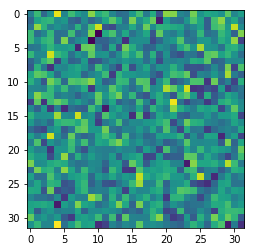

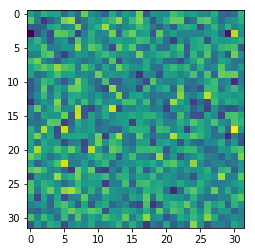

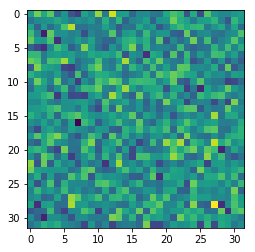

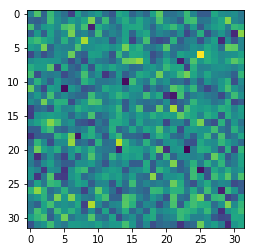

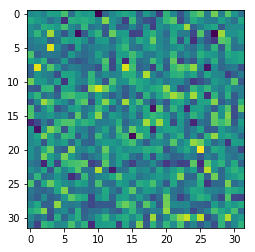

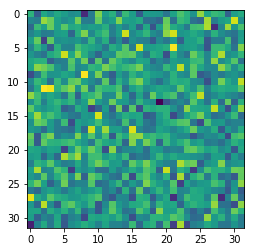

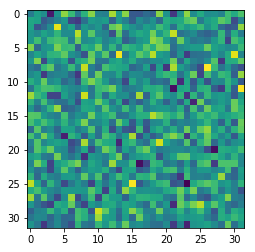

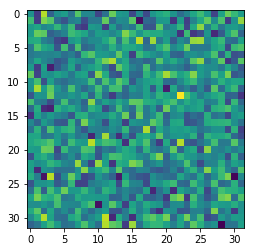

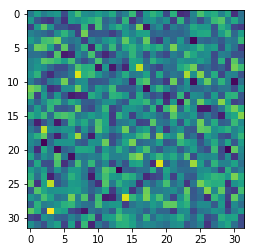

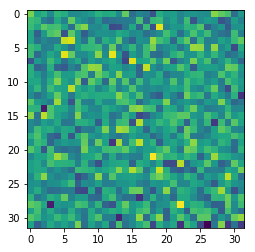

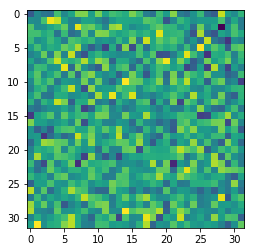

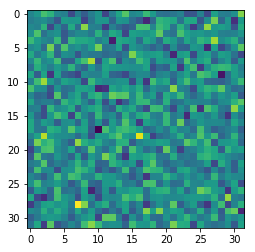

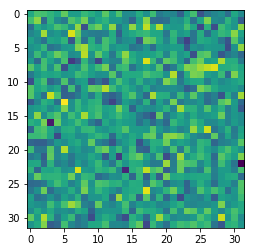

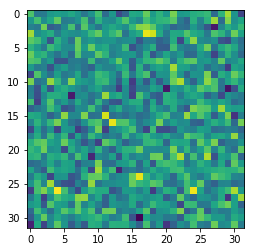

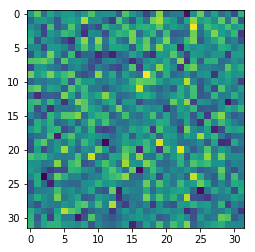

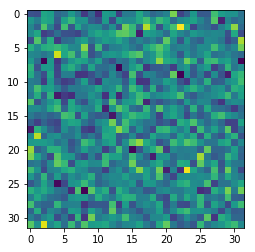

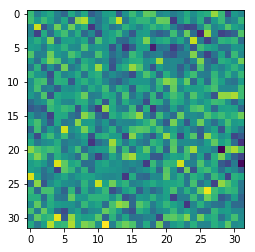

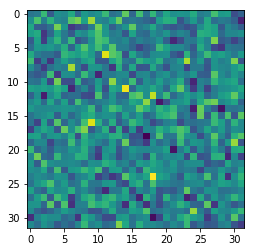

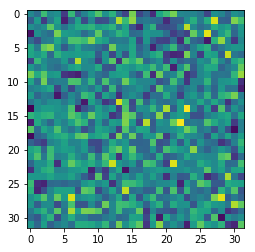

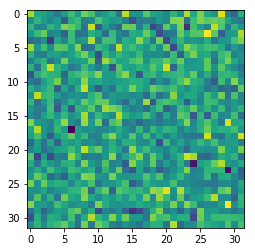

In [51]:
for i in range(20):
    component = data_transformed[:, i]
    vis = component.reshape((32, 32))
    
    f, axes = plt.subplots()
    axes.imshow(vis)

In [52]:
start = time.time()

partition = process_partition(noise_data) # generate partitions and run PCA on them
data_transformed, reconstructed_data = merge(noise_data, partition) # merge partitions

end = time.time()

print(f"Takes {end-start} sec")

Takes 1.3521392345428467 sec


In [53]:
orig_data = noise_data.reshape((1024, 1024))
diffsnorm(reconstructed_data, orig_data)

0.2228443120006138